## Position Context (WinCLIP based Attention)

In [1]:
from ksm import key_frame_selection
from data_loader import clip_path_loader
import torch
import torch.nn.functional as F
import cv2
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import clip
from fastprogress import progress_bar
from sklearn import metrics
from scipy.ndimage import gaussian_filter1d
import cv2
import textwrap, re
from transformers import logging

warnings.filterwarnings(action='ignore')
logging.set_verbosity_error()

/home/sha/anaconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
def print_long_string(long_string, width=70):
    wrapped_string = textwrap.fill(long_string, width)
    print(wrapped_string)

def extract_numbers(file_name):
    numbers = re.findall(r'(\d+)', file_name)
    return tuple(map(int, numbers))

def transform2pil(image, transform=True):
    if transform:
        image = image * 255
        image = np.transpose(image, [1, 2, 0])
        image = (image).astype(np.uint8)
    image_pil = Image.fromarray(image)
    return image_pil

def show_pil_image(pil_image):
    plt.figure(figsize=(6, 6))
    plt.imshow(pil_image)
    plt.axis('off')  
    plt.show()

In [25]:
def extract_score(text):
    match = re.search(r'(\d+(\.\d+)?)', text)
    if match:
        return float(match.group(0))
    else:
        return 0.0

def generate_output(text):
    result = {
        "score": extract_score(text),
        "reason": text
    }
    return result

def min_max_normalize(arr, eps=1e-8):
    min_val = np.min(arr)
    max_val = np.max(arr)
    denominator = max_val - min_val + eps  # Avoid division by zero
    normalized_arr = (arr - min_val) / denominator
    return normalized_arr

def show_score_graph(answers_idx, scores, auc, x='Frame', y='Anomaly Score'):
    length = len(scores)
    plt.clf()
    plt.plot([num for num in range(length)],[score for score in scores], label=f'AUC={auc:.2f}%') # plotting
    plt.bar(answers_idx, max(scores), width=1, color='r',alpha=0.5, label='Ground-truth') # check answer
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(fontsize=12)

---

0. Text Embedding 

In [3]:
class prompt_order():
    def __init__(self) -> None:
        super().__init__()
        self.template_list = [
            "a cropped photo of the {}.",
            "a close-up photo of a {}.",
            "a close-up photo of the {}.",
            "a bright photo of a {}.",
            "a bright photo of the {}.",
            "a dark photo of the {}.",
            "a dark photo of a {}.",
            "a jpeg corrupted photo of the {}.",
            "a jpeg corrupted photo of the {}.",
            "a blurry photo of the {}.",
            "a blurry photo of a {}.",
            "a photo of a {}.",
            "a photo of the {}.",
            "a photo of a small {}.",
            "a photo of the small {}.",
            "a photo of a large {}.",
            "a photo of the large {}.",
            "a photo of the {} for visual inspection.",
            "a photo of a {} for visual inspection.",
            "a photo of the {} for anomaly detection.",
            "a photo of a {} for anomaly detection."
        ]

    def prompt(self, class_name):
        input_ensemble_template = [template.format(class_name) for template in self.template_list]
        return input_ensemble_template

In [4]:
def make_text_embedding(model, device, text=None, type_list=None, class_adaption=False, template_adaption=False):
    text_generator = prompt_order()

    with torch.no_grad():
        if class_adaption:
            text_feature_arr = []
            for type in type_list:
                if template_adaption:
                    text_list = text_generator.prompt(type)
                    texts = clip.tokenize(text_list).to(device)
                else:
                    text_list = [type for _ in range(1)]
                    texts = clip.tokenize(text_list).to(device)
                text_features = model.encode_text(texts).float()
                avg_text_feature = torch.mean(text_features, dim = 0, keepdim= True) 
                text_feature_arr.append(avg_text_feature)
            text_embedding = torch.stack(text_feature_arr).squeeze(1)

        else:
            if template_adaption:
                text_list = text_generator.prompt(text)
                texts = clip.tokenize(text_list).to(device)
            else:
                text_list = [text for _ in range(1)]
                texts = clip.tokenize(text_list).to(device)
            text_features = model.encode_text(texts).float()
            text_embedding = torch.mean(text_features, dim = 0, keepdim= True) 
    return text_embedding

1. Patch Partition

In [5]:
def split_one_image_with_unfold(image_path, kernel_size=(80, 80), stride_size=None):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (240, 240)).astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float32')
    image = (image / 255)
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()  # (H, W, C) -> (C, H, W) -> (1, C, H, W)
    
    if stride_size == None:
        stride_size = kernel_size

    org_patches = F.unfold(image, kernel_size=(kernel_size[0], kernel_size[1]), stride=(stride_size[0], stride_size[1]))
    patches = org_patches.permute(0, 2, 1).reshape(-1, 3, kernel_size[0], kernel_size[1])
    patches = F.interpolate(patches, size=(224, 224), mode='bilinear')
    return patches

2. Patch Similarity Calculation

In [6]:
def patch_similarity(patches, text_embedding, model, device, class_adaption=False, type_id=None):
    with torch.no_grad():        
        patches = patches.to(device)
        image_embedding = model.encode_image(patches).float()
        image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
        text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
        similarity = (text_embedding @ image_embedding.T).cpu() # (1, patch_length) or (class_length, patch_length)

    if class_adaption:
        similarity = similarity.softmax(dim=0)
        return similarity[type_id]
    else:
        return similarity

3. Attention

In [7]:
def normalize(pred, max_value=None, min_value=None):
    if max_value is None or min_value is None:
        return (pred - pred.min()) / (pred.max() - pred.min())
    else:
        return (pred - min_value) / (max_value - min_value)

In [8]:
def attention(img_path, sim):
    img = cv2.cvtColor(cv2.resize(cv2.imread(img_path), (224, 224)), cv2.COLOR_BGR2RGB)
    mask = normalize(sim)
    mask = np.repeat(mask[:,:,np.newaxis], 3, axis=2)
    attn = (img * mask).astype(np.uint8)
    return attn

In [21]:
def winclip_attention(img_path, text_embedding, clip_model, device, class_adaption=False, type_id=None):
    patches_img = split_one_image_with_unfold(img_path, kernel_size=(240, 240)) # 1x1
    patches_lge = split_one_image_with_unfold(img_path, kernel_size=(80, 80)) # 3x3
    patches_mid = split_one_image_with_unfold(img_path, kernel_size=(48, 48)) # 5x5

    sim_img = patch_similarity(patches_img, text_embedding, clip_model, device, class_adaption, type_id).view(1, 1, 1, 1)
    sim_lge = patch_similarity(patches_lge, text_embedding, clip_model, device, class_adaption, type_id).view(1, 1, 3, 3)
    sim_mid = patch_similarity(patches_mid, text_embedding, clip_model, device, class_adaption, type_id).view(1, 1, 5, 5)

    usim_img = F.interpolate(sim_img, size=(224, 224), mode='bilinear').squeeze(0)
    usim_lge = F.interpolate(sim_lge, size=(224, 224), mode='bilinear').squeeze(0)
    usim_mid = F.interpolate(sim_mid, size=(224, 224), mode='bilinear').squeeze(0)
    usim_total = ((usim_img + usim_lge + usim_mid) / 3).squeeze(0).numpy()
    
    attentioned = attention(img_path, usim_total)
    output_image = transform2pil(attentioned, False)
    return output_image

----

## Load Model

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load('ViT-B/32', device=device)

In [11]:
from lvlm_func import load_lvlm, lvlm_test, make_instruction

[2025-01-08 14:35:25,072] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [12]:
# Model Parameter
model_path = "LVLM/weights/chatunivi"  # or "Chat-UniVi/Chat-UniVi-13B"
tokenizer, lvlm_model, image_processor = load_lvlm(model_path)

Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]


---

### Compare (Anomaly Detection)

In [44]:
video_folder_path = '/home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128'
lpath = '/home/sha/datasets/shanghai/testframemask/02_0128.npy' 
clip_length = 16

video_folder_name = video_folder_path.split('/')[-1]
video = clip_path_loader(video_folder_path, clip_length)
keyword = video_folder_path.split('/')[-2]

grid_path = save_dir_path = f'grid_save/{keyword}/{video_folder_name}'
if not os.path.exists(save_dir_path):
    os.makedirs(save_dir_path)
print('grid_path:', grid_path)

print(keyword)
print(len(video))

grid_path: grid_save/bicycle/02_0128
bicycle
28


In [45]:
type_list = ["car", "bicycle", "fighting", "throwing", "hand_truck", "running", "skateboarding", "falling", "jumping", "loitering", "motorcycle"]
type_ids = {}
for i, type in enumerate(type_list):
    type_ids[str(type)] = i  
type_id = type_ids[keyword]
print(type_id)

1


In [32]:
template_adaption = True
class_adaption = True
text_embedding = make_text_embedding(clip_model, device, text=keyword, type_list=type_list, 
                                     class_adaption=class_adaption, template_adaption=template_adaption)
print(text_embedding.shape)

torch.Size([11, 512])


1. w/o Position Context

In [46]:
predicted1 = []
insturuction = make_instruction(1, keyword)

for i, cp in enumerate(progress_bar(video, total=len(video))):
    # key frame selection
    key_path = key_frame_selection(cp, keyword, clip_model, clip_preprocess, device)
    print(i, key_path)

    # Anomaly Detection
    ad_response = lvlm_test(tokenizer, lvlm_model, image_processor, insturuction, key_path, None) 
    score = generate_output(ad_response)['score']

    # save anomaly score
    for _ in range(clip_length):
        predicted1.append(score)

0 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/010.jpg
1 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/023.jpg
2 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/036.jpg
3 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/062.jpg
4 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/079.jpg
5 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/089.jpg
6 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/102.jpg
7 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/126.jpg
8 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/130.jpg
9 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/159.jpg
10 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/173.jpg
11 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/189.jpg
12 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/204.jpg
13 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/214.jpg
14 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/238.jpg
15 /home/sha/datasets/cvad_data/c-s

2. w/ Position Context

0 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/010.jpg


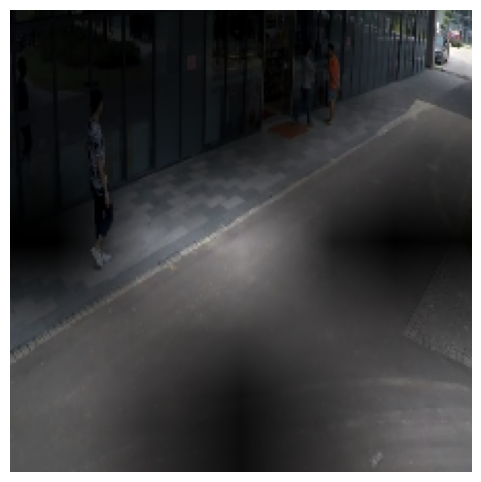

1 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/023.jpg


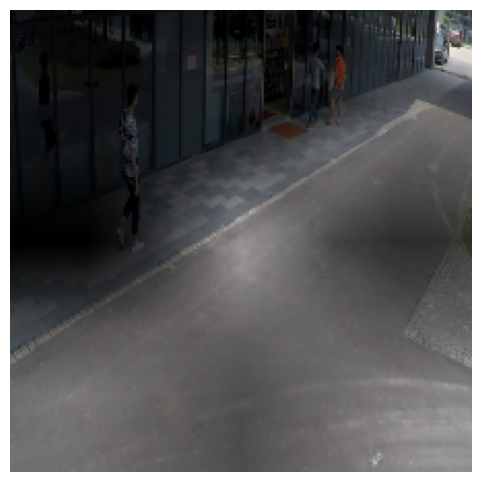

2 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/036.jpg


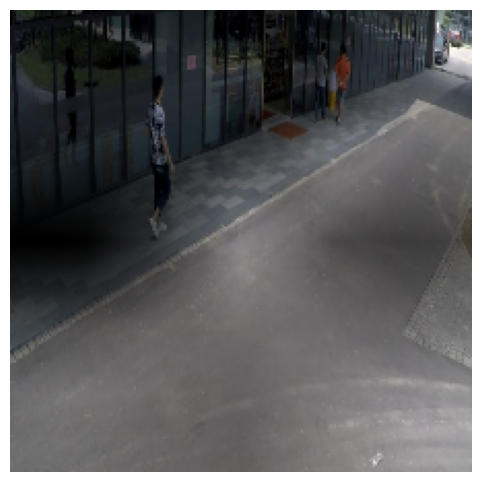

3 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/062.jpg


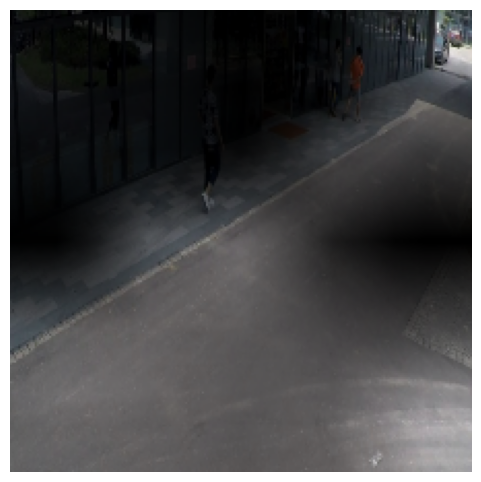

4 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/079.jpg


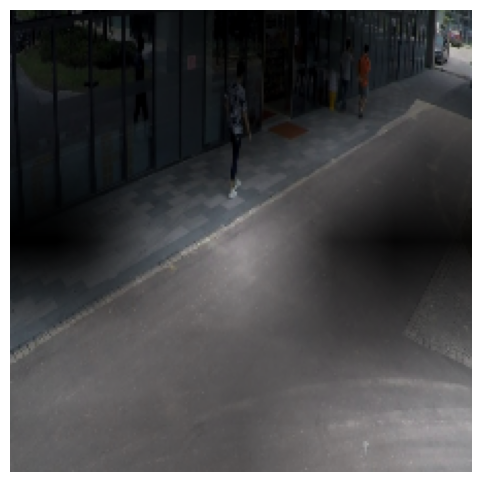

5 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/089.jpg


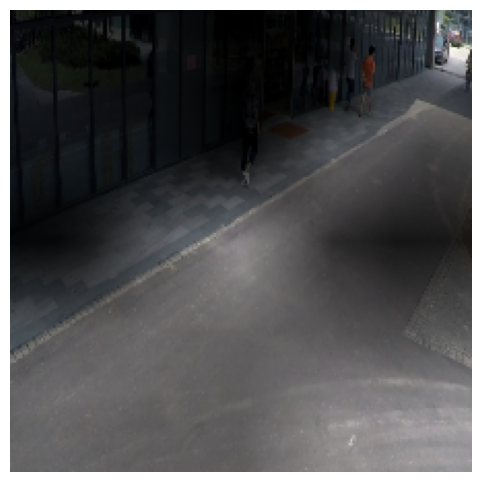

6 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/102.jpg


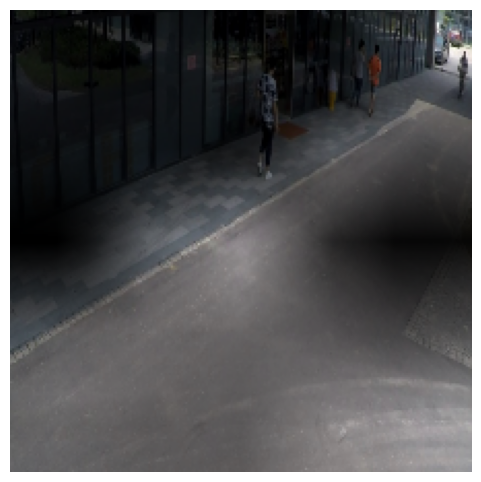

7 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/126.jpg


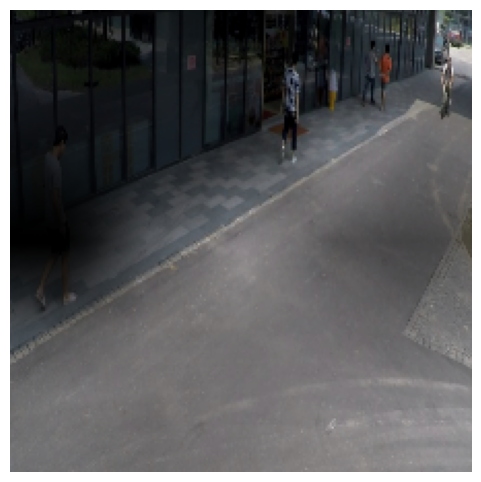

8 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/130.jpg


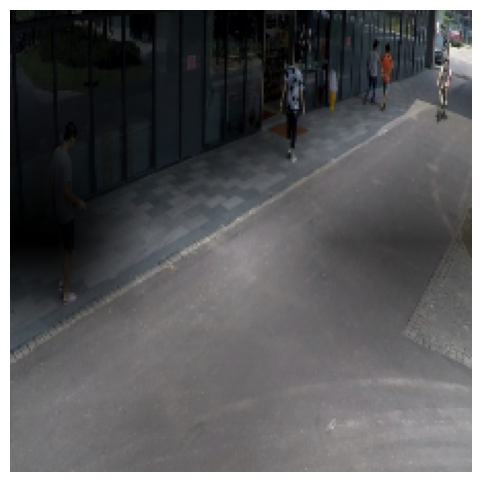

9 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/159.jpg


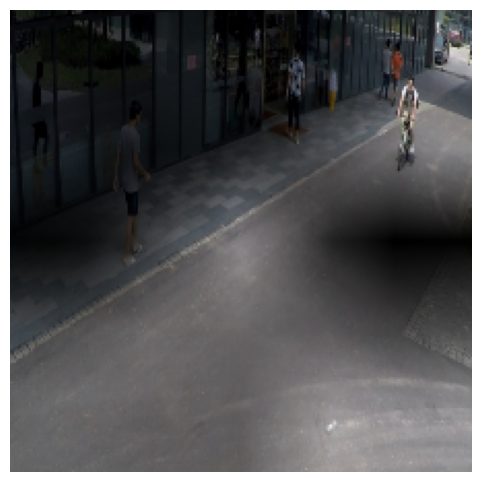

10 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/173.jpg


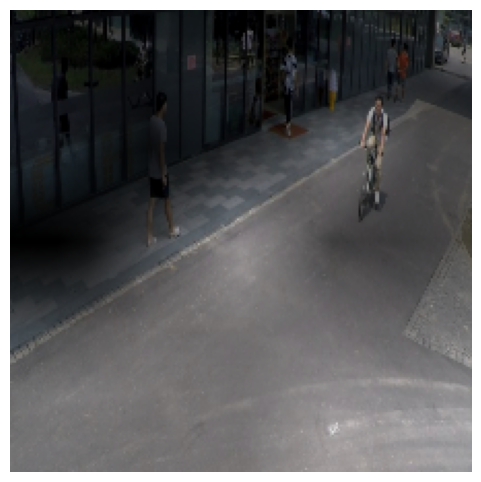

11 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/189.jpg


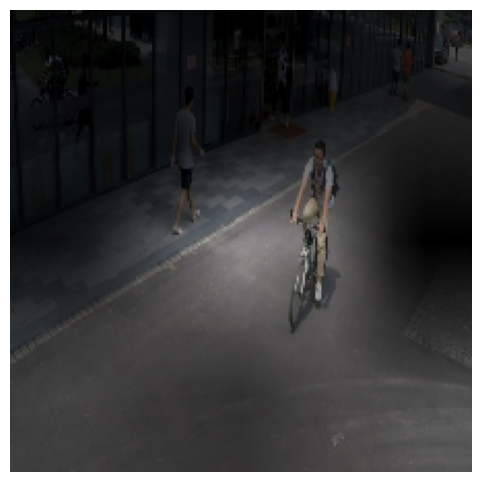

12 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/204.jpg


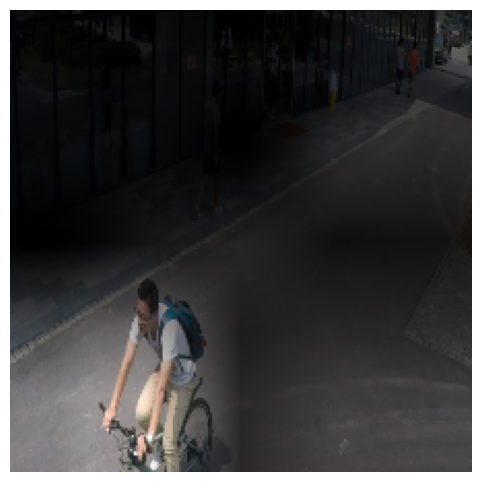

13 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/214.jpg


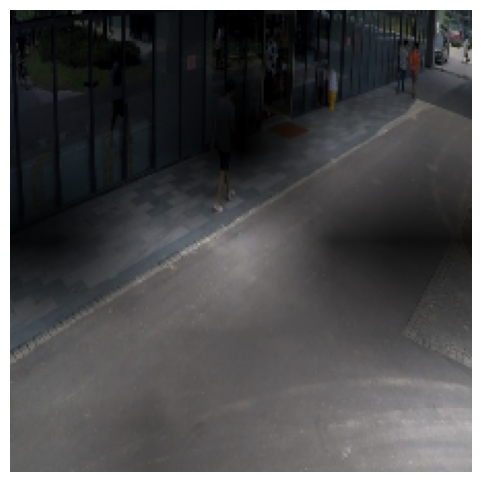

14 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/238.jpg


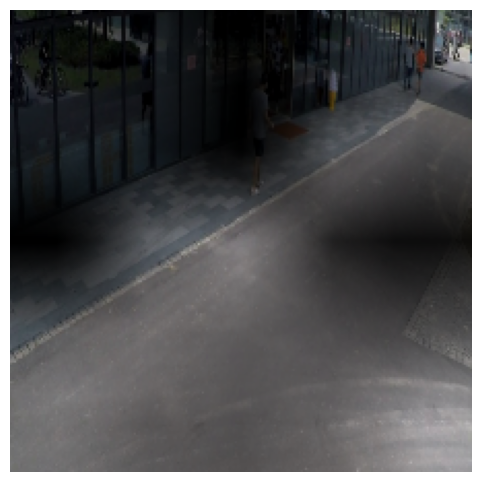

15 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/250.jpg


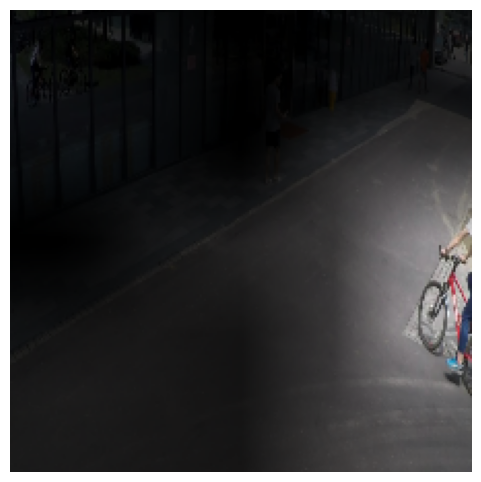

16 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/266.jpg


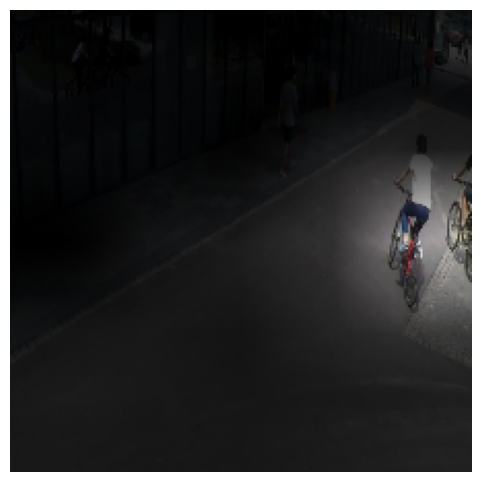

17 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/286.jpg


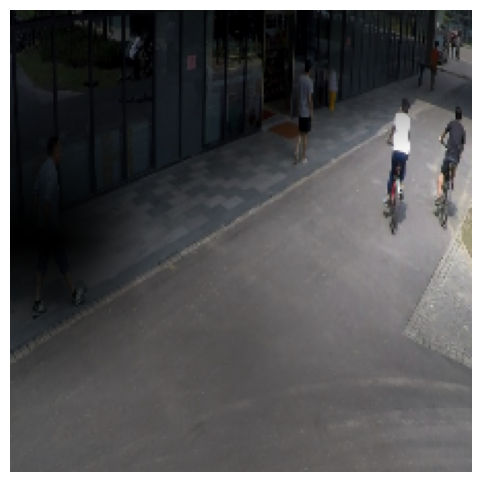

18 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/299.jpg


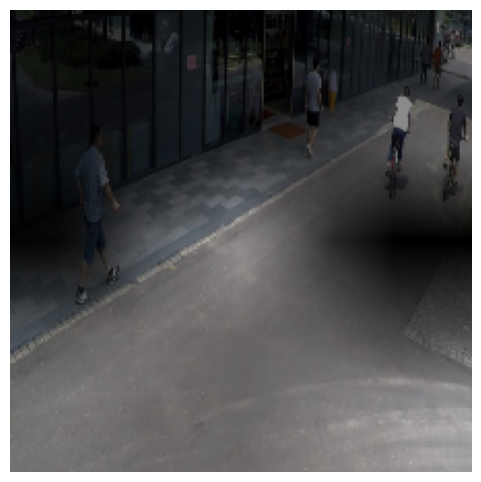

19 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/317.jpg


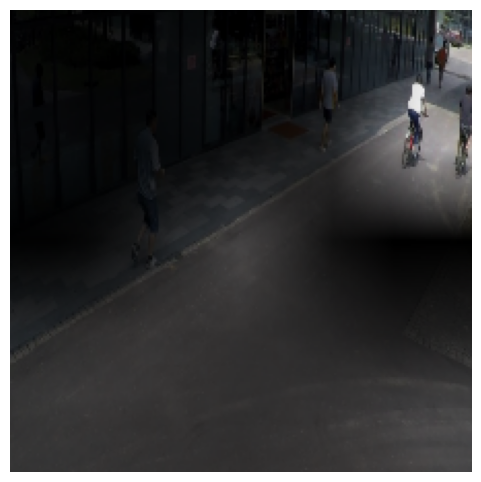

20 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/328.jpg


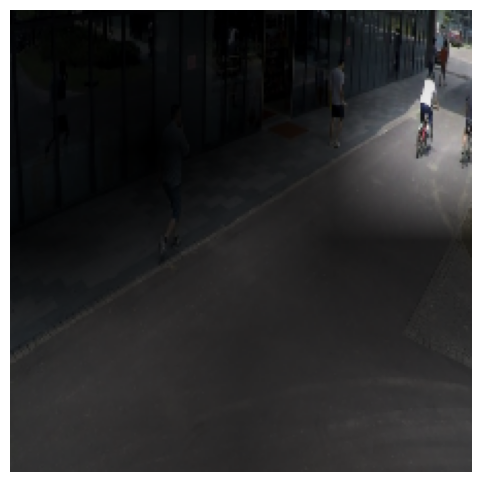

21 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/349.jpg


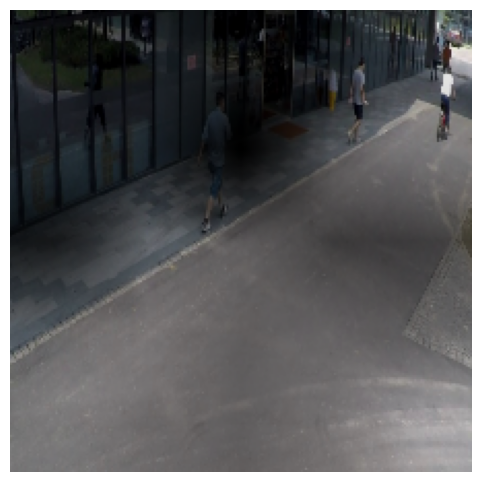

22 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/357.jpg


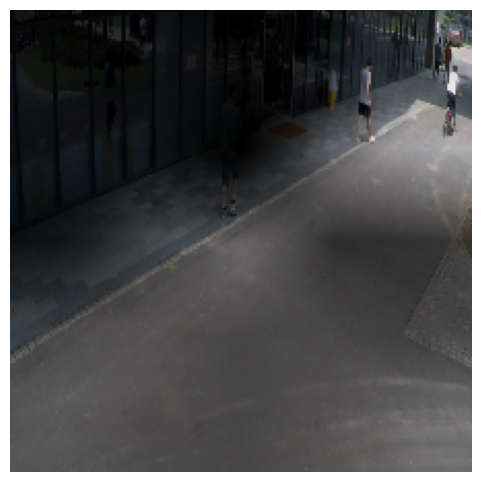

23 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/378.jpg


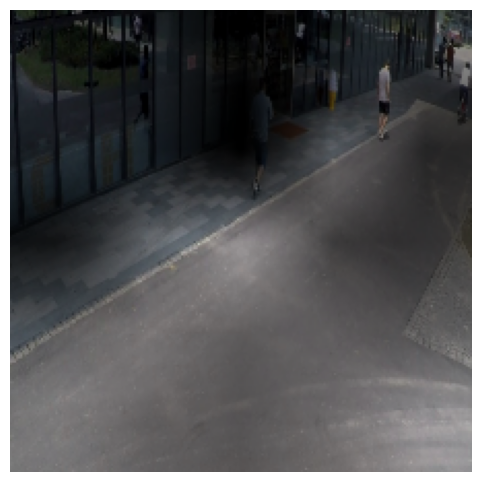

24 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/392.jpg


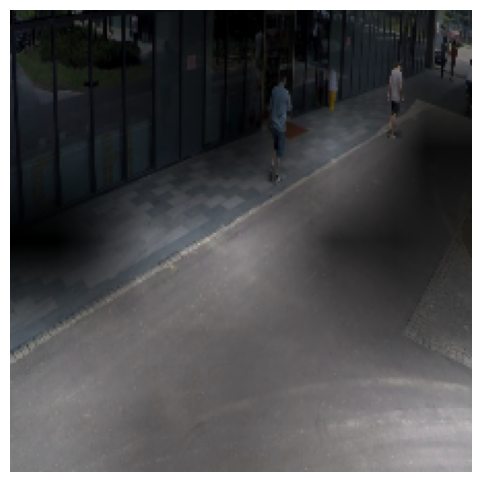

25 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/410.jpg


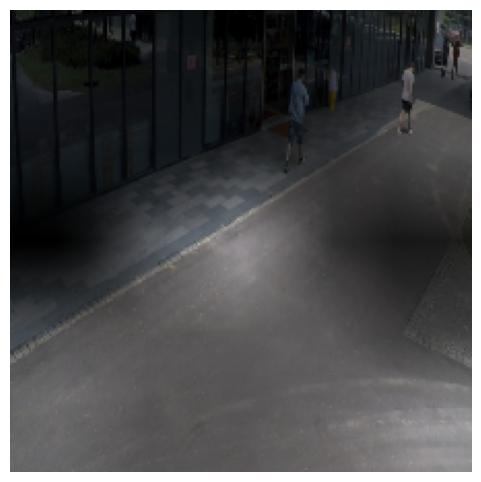

26 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/431.jpg


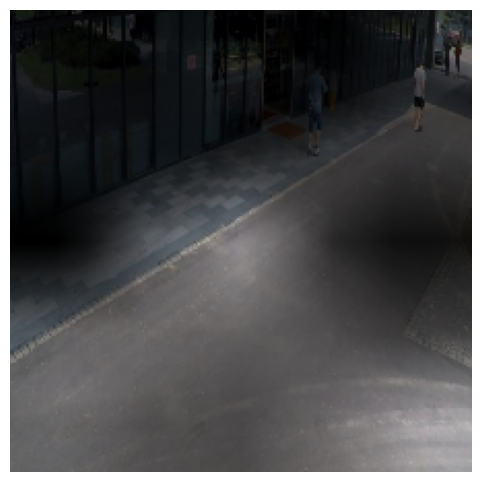

27 /home/sha/datasets/cvad_data/c-shtech/bicycle/02_0128/438.jpg


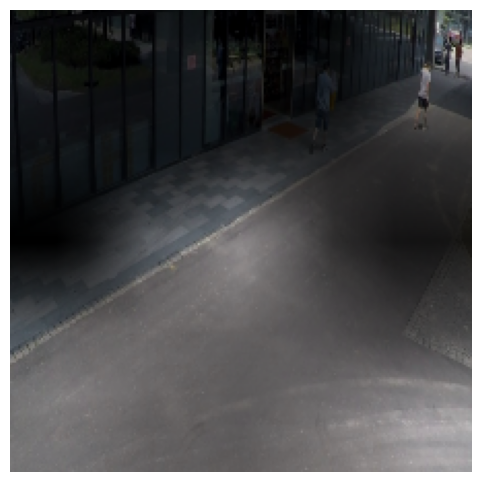

In [47]:
predicted2 = []
insturuction2 = make_instruction(1, keyword)

for i, cp in enumerate(progress_bar(video, total=len(video))):
    # key frame selection
    key_path = key_frame_selection(cp, keyword, clip_model, clip_preprocess, device)
    print(i, key_path)

    # position context generation
    wa_image = winclip_attention(key_path, text_embedding, clip_model, device, class_adaption, type_id)
    show_pil_image(wa_image)

    # Anomaly Detection
    generated_text = lvlm_test(tokenizer, lvlm_model, image_processor, insturuction2, None, wa_image)
    score = generate_output(generated_text)['score']

    # save anomaly score
    for _ in range(clip_length):
        predicted2.append(score)

In [48]:
gt = np.load(lpath)[:len(predicted2)]

sigma: 89 auc: 0.7263726919339164


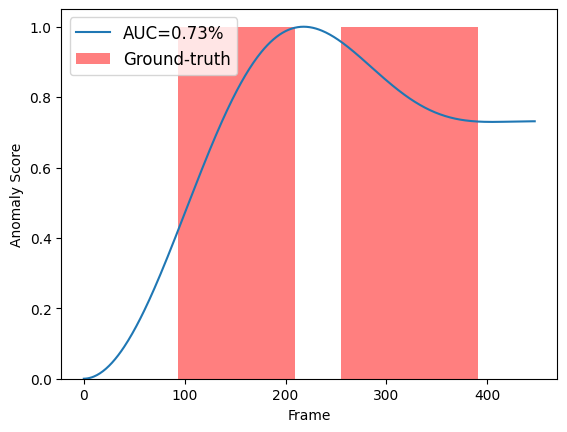

In [49]:
best_auc1 = 0 
for sigma in range(1, 100):
    g_predicted1 = gaussian_filter1d(predicted1, sigma=sigma)
    mm_predicted1 = min_max_normalize(g_predicted1)

    # get auc
    fpr, tpr, _ = metrics.roc_curve(gt, mm_predicted1, pos_label=1)
    auc1 = metrics.auc(fpr, tpr)

    if auc1 > best_auc1:
        best_sigma1 = sigma
        best_auc1 = auc1
        best_predicted1 = mm_predicted1  

# show anomaly scores and AUC
anomalies_idx = [i for i,l in enumerate(gt) if l==1] 
print('sigma:',best_sigma1, 'auc:',best_auc1)
show_score_graph(anomalies_idx, best_predicted1, best_auc1)

sigma: 12 auc: 0.93140589569161


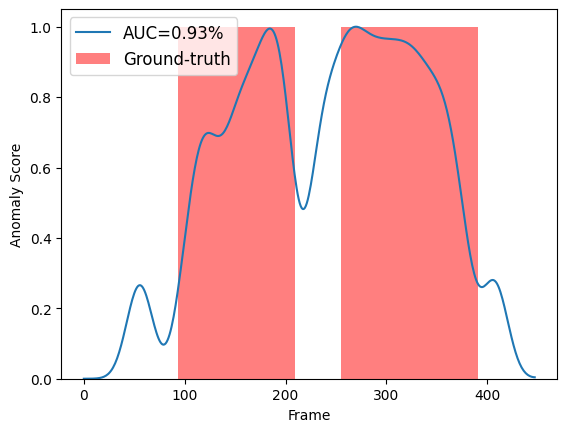

In [50]:
best_auc2 = 0 
for sigma in range(1, 100):
    g_predicted2 = gaussian_filter1d(predicted2, sigma=sigma)
    mm_predicted2 = min_max_normalize(g_predicted2)

    # get auc
    fpr, tpr, _ = metrics.roc_curve(gt, mm_predicted2, pos_label=1)
    auc2 = metrics.auc(fpr, tpr)
    
    # show
    if auc2 > best_auc2:
        best_sigma2 = sigma
        best_auc2 = auc2
        best_predicted2 = mm_predicted2  

# show anomaly scores and AUC
anomalies_idx = [i for i,l in enumerate(gt) if l==1] 
print('sigma:',best_sigma2, 'auc:',best_auc2)
show_score_graph(anomalies_idx, best_predicted2, best_auc2)